In [1]:
import ast
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from gym_tetris.actions import SIMPLE_MOVEMENT

In [2]:
def calc_iqm(data):
    sorted_data = np.sort(data)

    q1 = np.percentile(sorted_data, 25)
    q3 = np.percentile(sorted_data, 75)

    interquartile_range = sorted_data[(sorted_data >= q1) & (sorted_data <= q3)]

    return interquartile_range.mean()

In [3]:
def confidence_intervals(population,  parameter, n_sample = 100, iterasi=5000, alpha=0.05, stratified=False, aggregate = "iqm"):
    stats = np.array([])

    for _ in range(iterasi):
        if not stratified:
            sample = population[parameter].sample(n_sample, replace=True)
        else:
            sample = population.groupby('level', group_keys=False).apply(lambda x: x[parameter].sample(n=200, replace=True), include_groups=False).reset_index(drop=True)
        if aggregate == "iqm":
            stat = calc_iqm(sample)
        elif aggregate == "mean":
            stat = np.mean(sample)
        elif aggregate == "median":
            stat = np.median(sample)
        stats = np.append(stats, stat)

    lower_bound = np.percentile(stats, 100 * alpha / 2)
    upper_bound = np.percentile(stats, 100 * (1 - alpha / 2))
    
    return stats, lower_bound, upper_bound, np.mean(stats), np.std(stats)

In [71]:
def plot_interval(df: pd.DataFrame, title: str, metrics: list = [], levels: list = [], agg = "IQM"):
    fig, axes = plt.subplots(1, len(metrics), figsize=(6 * len(metrics), max(len(levels) * .5, 4)))
    axes = [axes] if len(metrics) == 1 else axes.flatten()

    color_palette = sns.color_palette('colorblind', n_colors=len(levels))
    colors = dict(zip(levels, color_palette))

    for m_idx, metric_name in enumerate(metrics): # IQM, mean, median dari suatu parameter
        ax = axes[m_idx]
        sub_df = df[df["parameter"] == metric_name]
        x_min, x_max = sub_df["lower_bound"].min(), sub_df["upper_bound"].max()
        ci_range = x_max - x_min
        padding = ci_range * .2
        ax.set_xlim(x_min - padding, x_max + padding)

        for idx, level in enumerate(levels): # biasanya level
            level_data = sub_df[sub_df["level"] == level]
            lower = level_data["lower_bound"].values[0]
            upper = level_data["upper_bound"].values[0]
            mean = level_data["mean"].values[0]
            
            # Plotkan interval kepercayaan untuk metrik (bar horizontal)
            ax.barh(y=idx, width=upper - lower, left=lower, height=0.7, alpha=0.75, color=colors[level], label=f'{metric_name} Interval' if idx == 0 else "")
            # Plotkan nilai rata-rata untuk metrik (garis vertikal)
            ax.vlines(x=mean, ymin=idx - 0.3, ymax=idx + 0.3, color='k', alpha=0.7)

        ax.set_yticks(list(range(len(levels))))
        ax.set_xticks(np.linspace(x_min, x_max, 100))
        ax.xaxis.set_major_locator(plt.MaxNLocator(8))
        # Set label untuk subplot
        if m_idx % 2 == 0:
            ax.set_yticklabels(levels, fontsize="medium")
            ax.set_ylabel("Level")
        else:
            ax.set_yticklabels([])

        ax.set_xlabel(f"{metric_name.replace('_', ' ').capitalize()} ({agg})")
        # ax.set_title(f"{metric_name.replace('_', ' ').capitalize()} {title}", fontsize='x-large')
        
        ax.tick_params(axis='both', which='major', length=0 if m_idx != 0 else 5)
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(True, axis='x', alpha=0.25)
        
    for j in range(len(metrics), len(axes)):
        fig.delaxes(axes[j])  # Menghapus subplot yang tidak digunakan

    # Coba gunakan tight_layout() untuk penyesuaian otomatis layout
    fig.text(0.46, 1, f"{title}", ha='center', fontsize='xx-large')
    # fig.suptitle(f"{title}", fontsize='xx-large')
    # plt.tight_layout(w_pad=3)  # Mengatur jarak antar subplot dengan padding
    plt.subplots_adjust(wspace=0.12, hspace=0.05, left=0.0)

    return fig, axes

In [5]:
def validate_95_percent_ci(data, lower_bound, upper_bound):
    count_in_range = np.sum((data >= lower_bound) & (data <= upper_bound))
    proportion_in_range = count_in_range / len(data)
    return proportion_in_range

In [6]:
def parse_board_heatmap(string_array):
    clean_str = string_array.replace('array(', '').replace(', dtype=uint8)', '').replace('\n', '')
    return np.array(ast.literal_eval(clean_str))

In [11]:
data = []
action_data = []
for i in range(11):
    if i == 0:
        df = pd.read_csv(f"./UNREAL-eval/CI/csv/10-slow.csv")
    else:
        df = pd.read_csv(f"./UNREAL-eval/CI/csv/{i}.csv")
    df["level"] = 9 + i
    df["lines_history"] = df["lines_history"].apply(lambda x: ast.literal_eval(x))
    df["board_history"] = df["board_history"].apply(parse_board_heatmap).apply(lambda x: np.sum(x, axis=0))
    
    action_freq = np.array([
        [seq.count(str(action)) for action in range(6)] for seq in df["action_taken"]
    ])
    total_action_freq = action_freq.sum(axis=0)

    action_freq_df = pd.DataFrame([total_action_freq], columns=[' '.join(item) for item in SIMPLE_MOVEMENT])
    action_freq_df["level"] = i + 10

    data.append(df)
    action_data.append(action_freq_df)

data = pd.concat(data, ignore_index=True)
action_data = pd.concat(action_data, ignore_index=True)

In [12]:
LINE_REWARDS = {1: 40, 2: 100, 3: 300, 4: 1200}

In [13]:
data["scaled_rewards"] = data.apply(
    lambda row: row["score"] + row["block_placed"] * 0.5 - row["level"] * sum(
        [LINE_REWARDS[line] for line in row["lines_history"]]
    ), axis=1
)
data["softdrop_rewards"] = data.apply(
    lambda row: row["score"] - (row["level"] + 1) * sum(
        [LINE_REWARDS[line] for line in row["lines_history"]]
    ), axis=1
)

In [14]:
max_r = data["scaled_rewards"].max()
min_r = data["scaled_rewards"].min()
data["normalized_rewards"] = data["scaled_rewards"].apply(
    lambda row: (row - min_r) / (max_r- min_r)
)

In [17]:
data.head()

,lines,score,rewards,block_placed,episode_time,episode_length,action_taken,lines_history,board_history,level,scaled_rewards,softdrop_rewards,normalized_rewards
0,0,0,-235.41,32,38.333931,2567,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",[],"[[0, 0, 9, 0, 1, 1, 1, 2, 2, 0], [0, 0, 9, 0, ...",9,16.0,0,0.096070
1,0,0,-231.93,28,34.883907,2173,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...",[],"[[9, 9, 0, 0, 1, 1, 2, 0, 0, 0], [10, 9, 0, 0,...",9,14.0,0,0.078603
2,0,2,-223.11,28,36.724746,2359,"[1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...",[],"[[0, 0, 0, 0, 0, 0, 3, 3, 0, 0], [7, 0, 0, 0, ...",9,16.0,2,0.096070
3,0,0,-218.70,28,38.298395,2359,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...",[],"[[0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, ...",9,14.0,0,0.078603
4,0,0,-233.34,31,39.805633,2457,"[1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...",[],"[[0, 0, 0, 0, 0, 1, 3, 3, 0, 0], [0, 7, 0, 0, ...",9,15.5,0,0.091703


In [142]:
data.to_csv(f"./UNREAL-eval/CI/master.csv")

In [18]:
cumsum_data = data.groupby('level')[["block_placed", "lines", "scaled_rewards", "softdrop_rewards"]].cumsum()
cumsum_data.columns = ["cumsum_blocks", "cumsum_lines", "cumsum_scaled_rewards", "cumsum_softdrop_rewards"]
cumsum_data["level"] = data["level"]

In [19]:
cumsum_data.groupby('level')["cumsum_lines"].max()

level
9      2
10     0
11     0
12     3
13     1
14     3
15     1
16     1
17     1
18     0
19    11
Name: cumsum_lines, dtype: int64

In [20]:
action_data = action_data.set_index("level")
action_data.head()

,NOOP,A,B,right,left,down
level,,,,,,
10,2655,3466,4864,11634,12242,444
11,3959,4266,1152,466,1534,2130
12,1729,4505,3552,4596,7956,402
13,5760,4072,833,1848,3428,2762
14,3094,3175,1423,1425,3518,1672


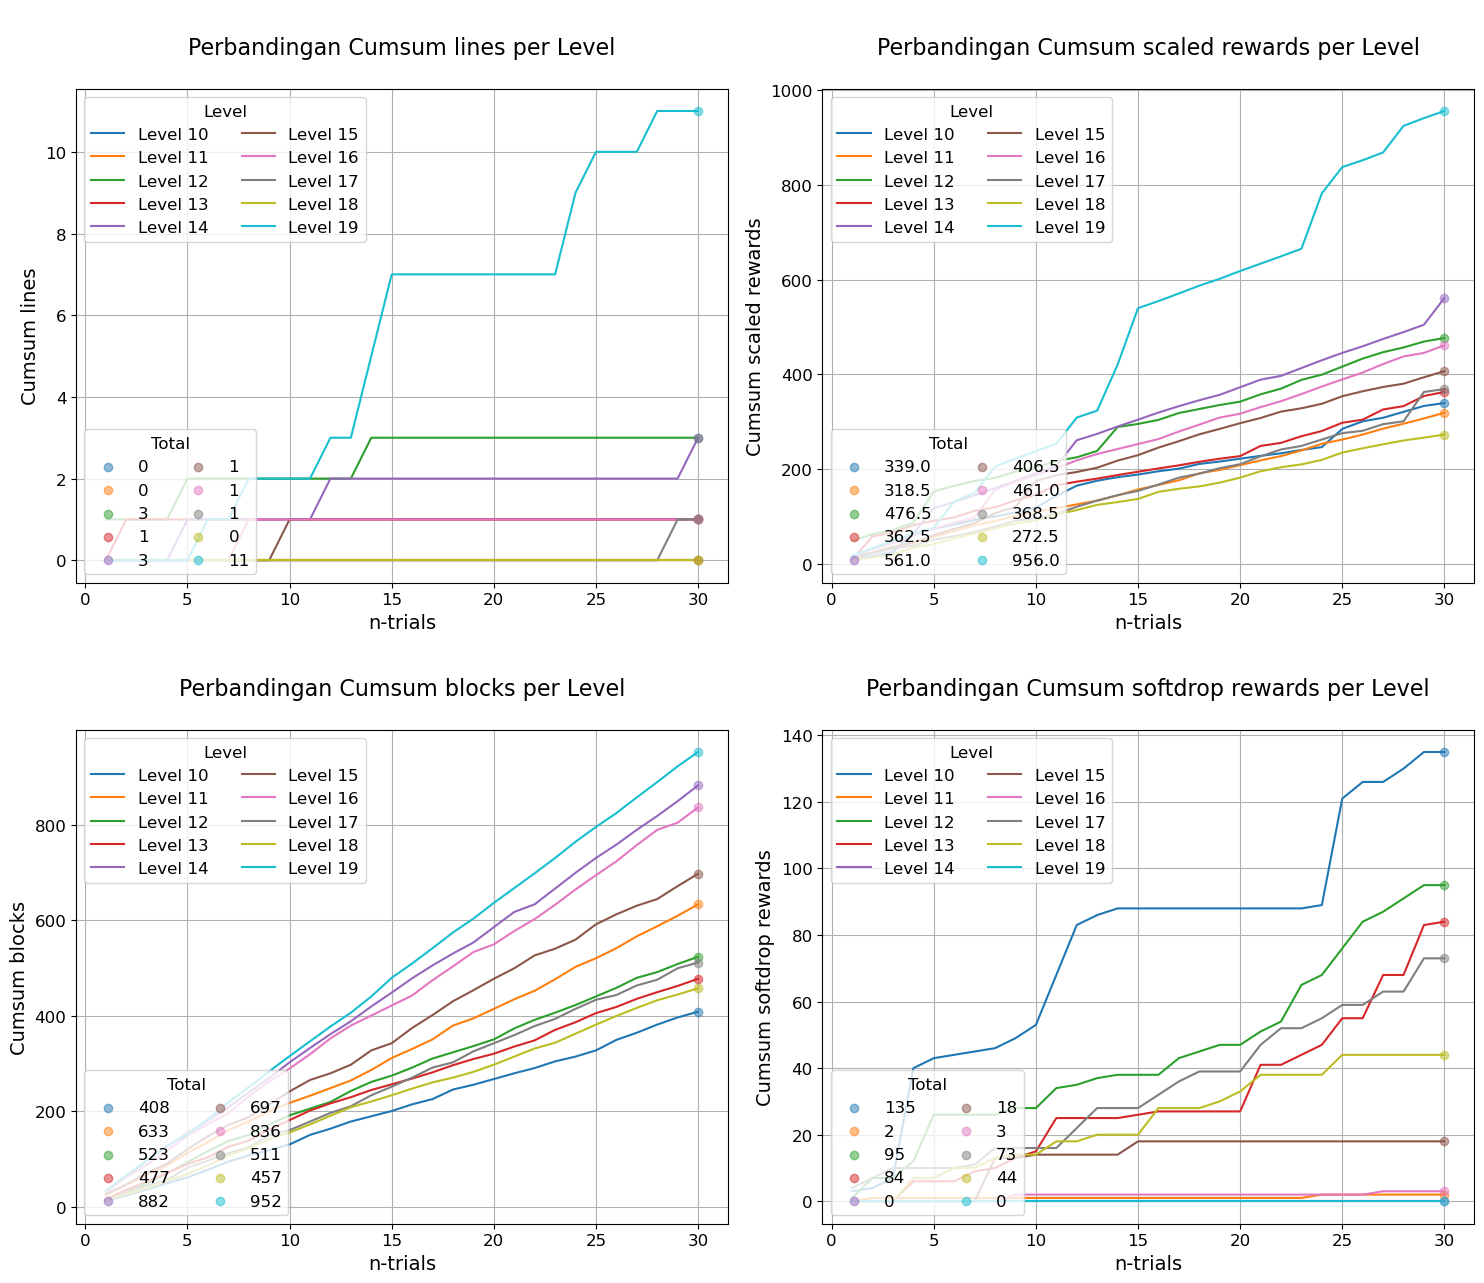

In [208]:
plt.rcParams.update({
    'font.size': 12,          # Ukuran font default
    'axes.titlesize': 16,     # Ukuran font judul plot
    'axes.labelsize': 14,     # Ukuran font label sumbu
    'xtick.labelsize': 12,    # Ukuran font tick label sumbu x
    'ytick.labelsize': 12,    # Ukuran font tick label sumbu y
    'legend.fontsize': 12,    # Ukuran font legend
})
metrics = [ 'cumsum_lines', 'cumsum_scaled_rewards', 'cumsum_blocks', 'cumsum_softdrop_rewards', ]

# Membuat subplot untuk setiap metrik
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 13))
axes = axes.flatten()  # Mengubah axes menjadi array 1D untuk memudahkan iterasi

# Plotting untuk setiap metrik
for i, metric in enumerate(metrics):
    lines = []  # Untuk menyimpan objek line
    dots = []   # Untuk menyimpan objek dot
    for level in range(10):
        level_data = cumsum_data[cumsum_data['level'] == level + 10]
        line, = axes[i].plot(range(1, len(level_data) + 1), level_data[metric], label=f"Level {level + 10}")
        lines.append(line)
        max_value = level_data[metric].max()  # Ambil nilai maksimum
        dot = axes[i].scatter(30, max_value, zorder=10, label=f'{max_value}', alpha=0.5) # Plot titik tertinggi
        dots.append(dot)

    metric = metric.replace("_", " ").capitalize()
    axes[i].set_title(f'\nPerbandingan {metric} per Level\n')
    axes[i].set_ylabel(metric)
    axes[i].set_xlabel('n-trials')
    legend1 = axes[i].legend(handles=lines, loc='upper left', title='Level', ncol=2)
    axes[i].add_artist(legend1)  # Menambahkan legend pertama ke axes

    # Membuat legend kedua (Max Value)
    legend2 = axes[i].legend(handles=dots, loc='lower left', title='Total', ncol=2)
    axes[i].grid(True)  # Menambahkan grid untuk memudahkan pembacaan
    axes[i].set_xticks([1] + list(range(5, 31, 5)))

    axes[i].xaxis.set_major_locator(plt.MaxNLocator(7))
plt.tight_layout()  # Agar subplot tidak tumpang tindih
plt.show()

In [24]:
cumsum_data.groupby('level')["cumsum_scaled_rewards"].max()

level
9     517.5
10    339.0
11    318.5
12    476.5
13    362.5
14    561.0
15    406.5
16    461.0
17    368.5
18    272.5
19    956.0
Name: cumsum_scaled_rewards, dtype: float64

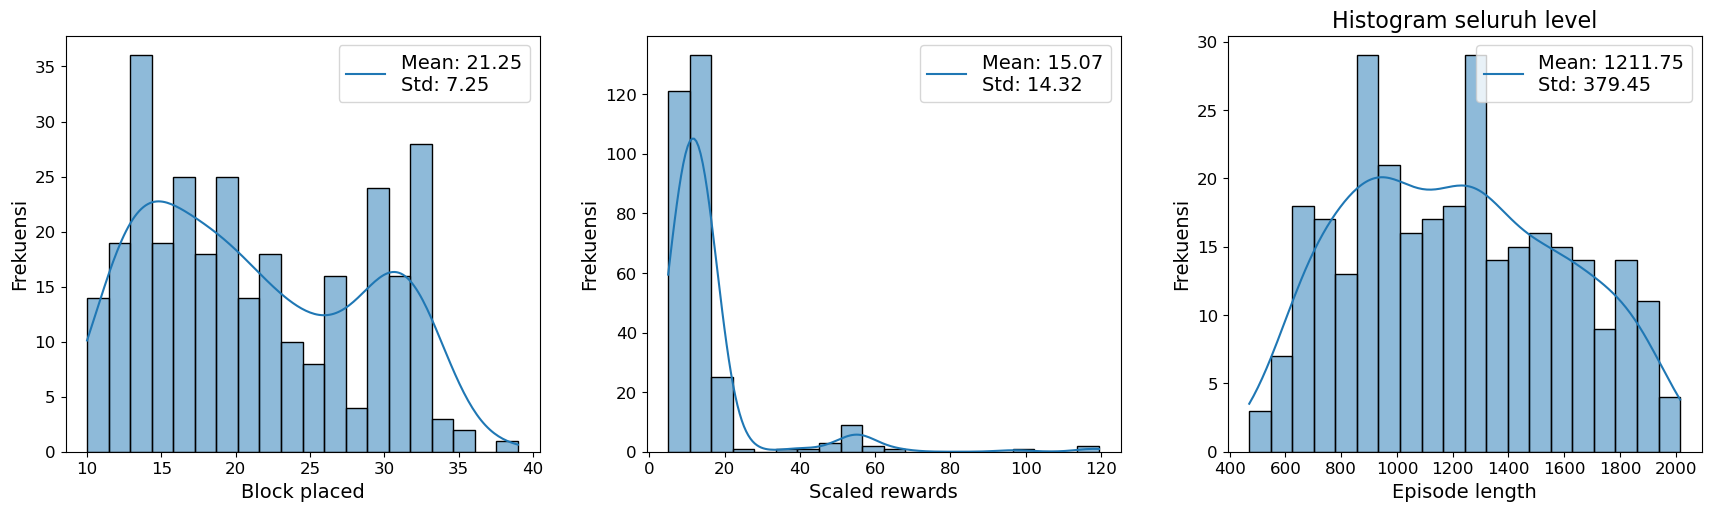

In [118]:
plt.rcParams.update({
    'font.size': 13,          # Ukuran font default
    'axes.titlesize': 16,     # Ukuran font judul plot
    'axes.labelsize': 14,     # Ukuran font label sumbu
    'xtick.labelsize': 12,    # Ukuran font tick label sumbu x
    'ytick.labelsize': 12,    # Ukuran font tick label sumbu y
    'legend.fontsize': 14,    # Ukuran font legend
})

fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 baris, 2 kolom
for i, parameter in enumerate(["block_placed", "scaled_rewards", "episode_length"]):
    # Membuat histogram distribusi data
    mean = data[data["level"] != 9][parameter].mean()
    std = data[data["level"] != 9][parameter].std()
    sns.histplot(data[data["level"] != 9][parameter], bins=20, kde=True, stat="count", ax=axes[i])
    label = f'Mean: {mean:.2f}\nStd: {std:.2f}'

    # Menambahkan keterangan (legend)
    axes[i].legend([label], loc='upper right', fontsize=14)

    # Melabeli judul, sumbu-X, dan sumbu-Y
    axes[i].set_xlabel(f'{parameter.replace("_", " ").capitalize()}')
    axes[i].set_ylabel('Frekuensi')

plt.title('Histogram seluruh level')
plt.tight_layout(pad=3.0, h_pad=2.0, w_pad=2.0)
plt.show()

In [62]:
generalized_data = []
for i, parameter in enumerate(["block_placed", "scaled_rewards", "episode_length"]):
    stats, lb, ub, mean, std = confidence_intervals(data[data["level"] != 9], parameter, stratified=True, aggregate="iqm")
    generalized_data.append([stats, lb, ub, mean, std, parameter])

generalized_df = pd.DataFrame(generalized_data, columns=["stat", "lower_bound", "upper_bound", "mean", "std", "parameter"]).drop(columns=["stat"])
generalized_df["level"] = "10 - 19"
generalized_df.head()

,lower_bound,upper_bound,mean,std,parameter,level
0,20.082363,20.952130,20.432380,0.253820,block_placed,10 - 19
1,11.843399,12.557163,12.218104,0.213341,scaled_rewards,10 - 19
2,1177.350124,1204.018225,1191.133207,6.757654,episode_length,10 - 19


(<Figure size 1800x400 with 3 Axes>,
 array([<Axes: xlabel='Block placed (IQM)', ylabel='Level'>,
        <Axes: xlabel='Scaled rewards (IQM)'>,
        <Axes: xlabel='Episode length (IQM)', ylabel='Level'>],
       dtype=object))

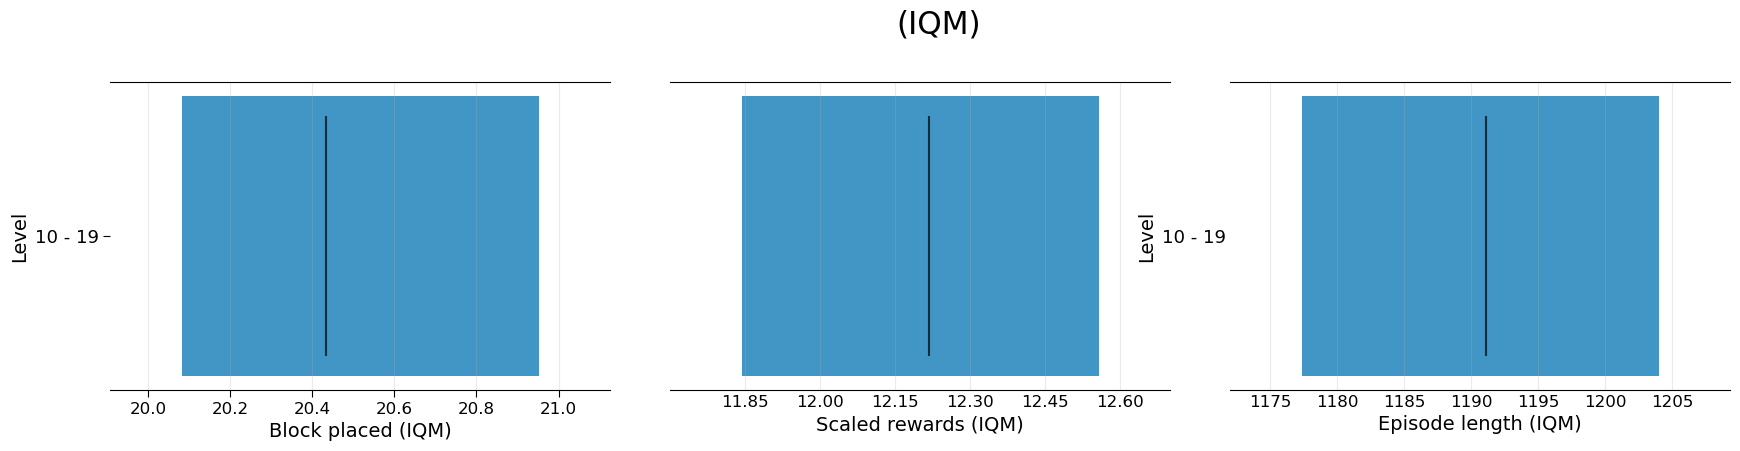

In [63]:
plot_interval(generalized_df, "(IQM)", generalized_df.parameter.unique(), generalized_df.level.unique())

Percentage: 95.0%
Percentage: 95.0%
Percentage: 95.0%


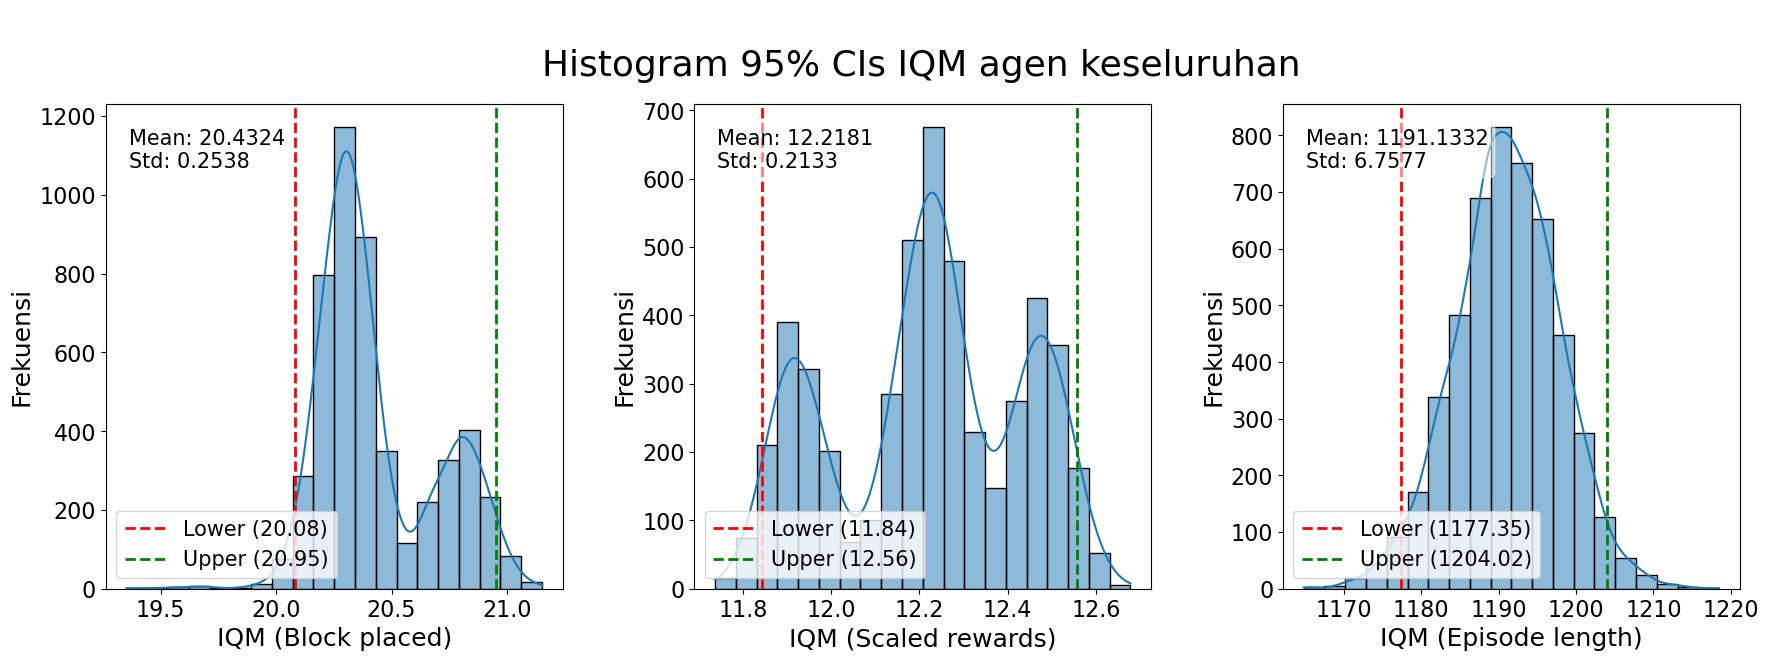

In [182]:
plt.rcParams.update({
    'font.size': 18,          # Ukuran font default
    'axes.titlesize': 16,     # Ukuran font judul plot
    'axes.labelsize': 18,     # Ukuran font label sumbu
    'xtick.labelsize': 16,    # Ukuran font tick label sumbu x
    'ytick.labelsize': 16,    # Ukuran font tick label sumbu y
    'legend.fontsize': 18,    # Ukuran font legend
})

fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 baris, 2 kolom
axes = axes.flatten()
for i, parameter in enumerate(["block_placed", "scaled_rewards", "episode_length"]):
    stats, lb, ub, mean, std, _ = generalized_data[i]

    # Membuat histogram distribusi data
    sns.histplot(stats, ax=axes[i], kde=True, stat="count", bins=20)

    # Membuat garis lower dan upper bound
    axes[i].axvline(lb, color='r', linestyle='dashed', linewidth=2, label=f'Lower ({lb:.2f})')
    axes[i].axvline(ub, color='g', linestyle='dashed', linewidth=2, label=f'Upper ({ub:.2f})')

    axes[i].text(0.05, 0.95, f'Mean: {mean:.4f}\nStd: {std:.4f}', transform=axes[i].transAxes,
            fontsize=15, va='top', ha='left', bbox=dict(boxstyle="round", alpha=0.5, color="white"))

    # Menambahkan keterangan (legend)
    axes[i].legend(loc='lower left', fontsize=15)

    # Melabeli judul, sumbu-X, dan sumbu-Y
    axes[i].set_xlabel(f'IQM ({parameter.replace("_", " ").capitalize()})')
    axes[i].set_ylabel('Frekuensi')

    is_valid = validate_95_percent_ci(stats, lb, ub)
    print(f"Percentage: {is_valid * 100}%")

# plt.tight_layout()  # Mengatur layout agar tidak overlap
fig.text(0.52, 1, f"\nHistogram 95% CIs IQM agen keseluruhan", ha='center', fontsize='x-large')
plt.tight_layout(pad=1.0, w_pad=2.0)
plt.show()

In [68]:
generalized_data_mean = []
for i, parameter in enumerate(["block_placed", "scaled_rewards", "episode_length"]):
    stats, lb, ub, mean, std = confidence_intervals(data[data["level"] != 9], parameter, stratified=True, aggregate="mean")
    generalized_data_mean.append([stats, lb, ub, mean, std, parameter])

generalized_df_mean = pd.DataFrame(generalized_data_mean, columns=["stat", "lower_bound", "upper_bound", "mean", "std", "parameter"]).drop(columns=["stat"])
generalized_df_mean["level"] = "10 - 19"
generalized_df_mean.head()

,lower_bound,upper_bound,mean,std,parameter,level
0,21.090000,21.417000,21.254033,0.084446,block_placed,10 - 19
1,14.513231,15.640006,15.068617,0.288501,scaled_rewards,10 - 19
2,1202.277350,1221.541663,1211.774860,5.000781,episode_length,10 - 19


(<Figure size 1800x400 with 3 Axes>,
 array([<Axes: xlabel='Block placed (IQM)', ylabel='Level'>,
        <Axes: xlabel='Scaled rewards (IQM)'>,
        <Axes: xlabel='Episode length (IQM)', ylabel='Level'>],
       dtype=object))

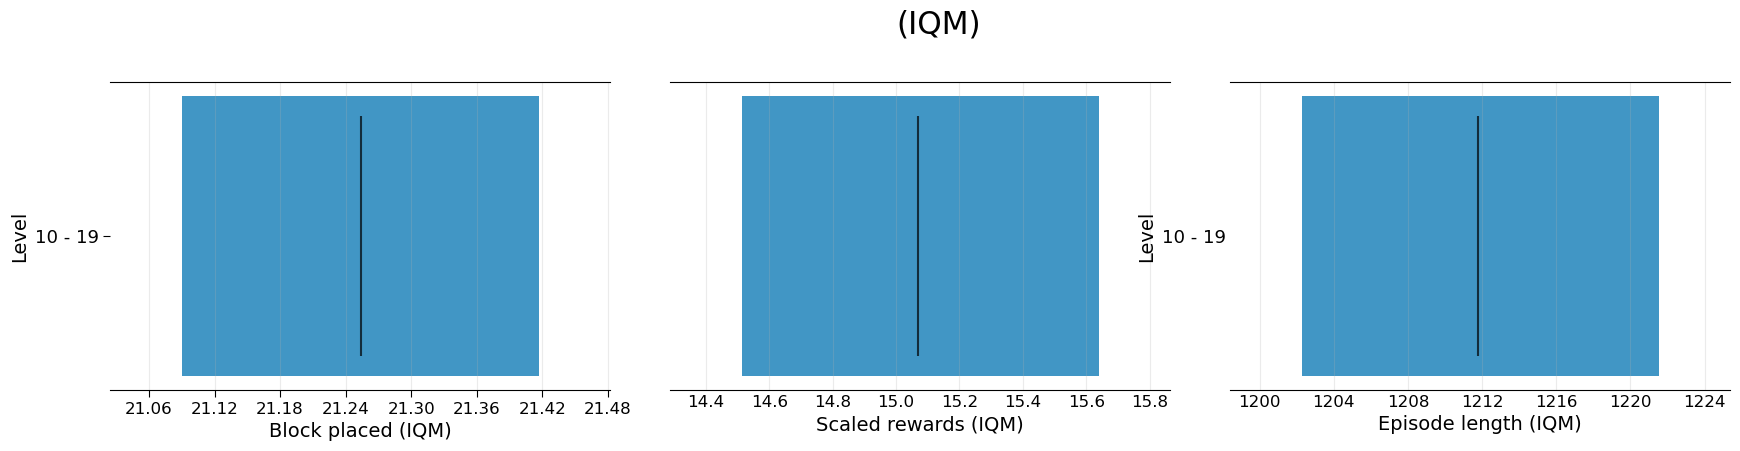

In [69]:
plot_interval(generalized_df_mean, "(IQM)", generalized_df_mean.parameter.unique(), generalized_df_mean.level.unique())

Percentage: 95.06%
Percentage: 95.0%
Percentage: 95.0%


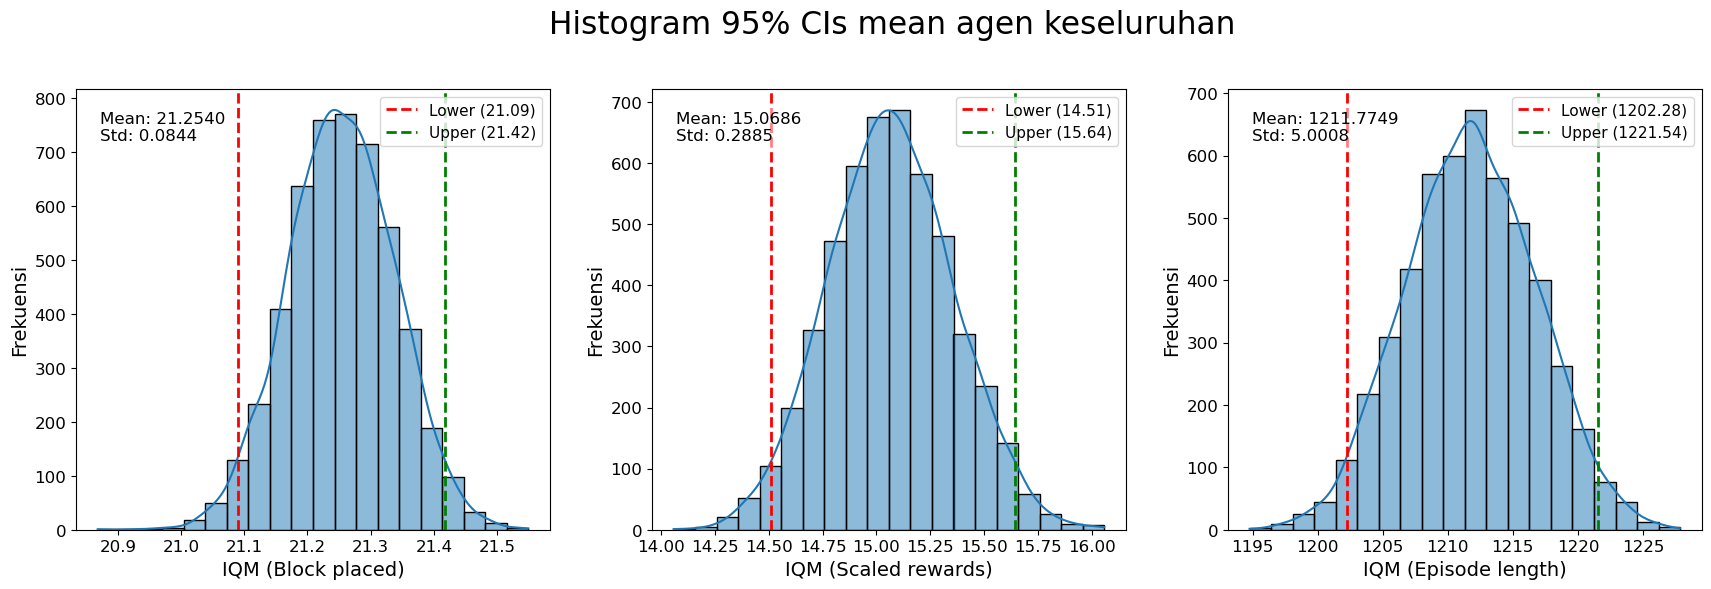

In [82]:
plt.rcParams.update({
    'font.size': 13,          # Ukuran font default
    'axes.titlesize': 16,     # Ukuran font judul plot
    'axes.labelsize': 14,     # Ukuran font label sumbu
    'xtick.labelsize': 12,    # Ukuran font tick label sumbu x
    'ytick.labelsize': 12,    # Ukuran font tick label sumbu y
    'legend.fontsize': 12,    # Ukuran font legend
})

fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 baris, 2 kolom
axes = axes.flatten()
for i, parameter in enumerate(["block_placed", "scaled_rewards", "episode_length"]):
    stats, lb, ub, mean, std, _ = generalized_data_mean[i]

    # Membuat histogram distribusi data
    sns.histplot(stats, ax=axes[i], kde=True, stat="count", bins=20)

    # Membuat garis lower dan upper bound
    axes[i].axvline(lb, color='r', linestyle='dashed', linewidth=2, label=f'Lower ({lb:.2f})')
    axes[i].axvline(ub, color='g', linestyle='dashed', linewidth=2, label=f'Upper ({ub:.2f})')

    axes[i].text(0.05, 0.95, f'Mean: {mean:.4f}\nStd: {std:.4f}', transform=axes[i].transAxes,
            fontsize=12, va='top', ha='left', bbox=dict(boxstyle="round", alpha=0.5, color="white"))

    # Menambahkan keterangan (legend)
    axes[i].legend(loc='upper right', fontsize=11)

    # Melabeli judul, sumbu-X, dan sumbu-Y
    axes[i].set_xlabel(f'IQM ({parameter.replace("_", " ").capitalize()})')
    axes[i].set_ylabel('Frekuensi')

    is_valid = validate_95_percent_ci(stats, lb, ub)
    print(f"Percentage: {is_valid * 100}%")

# plt.tight_layout()  # Mengatur layout agar tidak overlap
fig.text(0.52, 1, f"Histogram 95% CIs mean agen keseluruhan", ha='center', fontsize='xx-large')
plt.tight_layout(pad=3.0, w_pad=2.0)
plt.show()

In [191]:
level_data = []
for i, parameter in enumerate(["block_placed", "scaled_rewards", "episode_length"]):
    for i in range(11):
        data_level = data[data["level"] == i+9]
        stats, lb, ub, mean, std = confidence_intervals(data_level, parameter, aggregate="iqm")
        level_data.append([stats, lb, ub, mean, std, i + 9, parameter])

level_df = pd.DataFrame(
    level_data,
    columns=["stat", "lower_bound", "upper_bound", "mean", "std", "level", "parameter"],
).drop(columns=['stat'])
level_df.head()

,lower_bound,upper_bound,mean,std,level,parameter
0,28.612835,30.285714,29.456731,0.455975,9,block_placed
1,12.028571,13.482143,12.728970,0.421037,10,block_placed
2,20.120639,22.353871,21.130400,0.551371,11,block_placed
3,16.084710,18.322048,17.083036,0.599778,12,block_placed
4,14.194030,16.166721,14.948891,0.519970,13,block_placed


(<Figure size 1800x500 with 3 Axes>,
 array([<Axes: xlabel='Block placed (IQM)', ylabel='Level'>,
        <Axes: xlabel='Scaled rewards (IQM)'>,
        <Axes: xlabel='Episode length (IQM)', ylabel='Level'>],
       dtype=object))

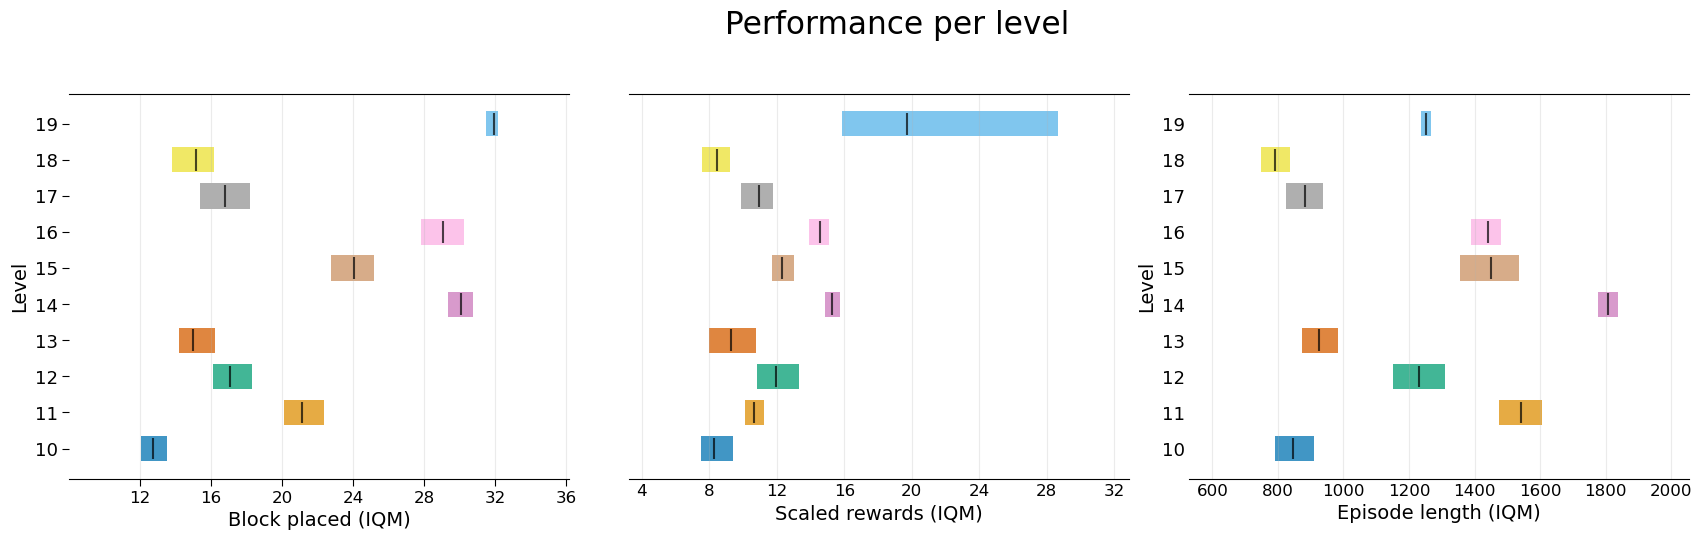

In [80]:
subpop = level_df[level_df["level"] > 9]
plot_interval(subpop, "Performance per level", subpop.parameter.unique(), subpop.level.unique())

In [202]:
level_data_mean = []
for i, parameter in enumerate(["block_placed", "scaled_rewards", "episode_length"]):
    for i in range(11):
        data_level = data[data["level"] == i+9]
        stats, lb, ub, mean, std = confidence_intervals(data_level, parameter, aggregate="mean")
        level_data_mean.append([stats, lb, ub, mean, std, i + 9, parameter])

level_df_mean = pd.DataFrame(
    level_data_mean,
    columns=["stat", "lower_bound", "upper_bound", "mean", "std", "level", "parameter"],
).drop(columns=['stat'])
level_df["width"] = level_df["upper_bound"] - level_df["lower_bound"]
level_df_mean.head()

,lower_bound,upper_bound,mean,std,level,parameter
0,28.44000,29.61000,29.033426,0.298830,9,block_placed
1,13.03000,14.20025,13.600134,0.303287,10,block_placed
2,20.42000,21.79000,21.103062,0.346589,11,block_placed
3,16.72000,18.15000,17.428500,0.360165,12,block_placed
4,15.24975,16.56000,15.897170,0.332230,13,block_placed


In [203]:
level_df

,lower_bound,upper_bound,mean,std,level,parameter,width
0,28.612835,30.285714,29.456731,0.455975,9,block_placed,1.672879
1,12.028571,13.482143,12.728970,0.421037,10,block_placed,1.453571
2,20.120639,22.353871,21.130400,0.551371,11,block_placed,2.233232
3,16.084710,18.322048,17.083036,0.599778,12,block_placed,2.237337
4,14.194030,16.166721,14.948891,0.519970,13,block_placed,1.972691
5,29.338983,30.745763,30.062631,0.359924,14,block_placed,1.406780
6,22.724638,25.142857,24.041825,0.631843,15,block_placed,2.418219
7,27.835997,30.273978,29.093675,0.664553,16,block_placed,2.437981
8,15.403226,18.142922,16.802410,0.750212,17,block_placed,2.739696
9,13.816874,16.180365,15.136366,0.681406,18,block_placed,2.363492


(<Figure size 1800x500 with 3 Axes>,
 array([<Axes: xlabel='Block placed (mean)', ylabel='Level'>,
        <Axes: xlabel='Scaled rewards (mean)'>,
        <Axes: xlabel='Episode length (mean)', ylabel='Level'>],
       dtype=object))

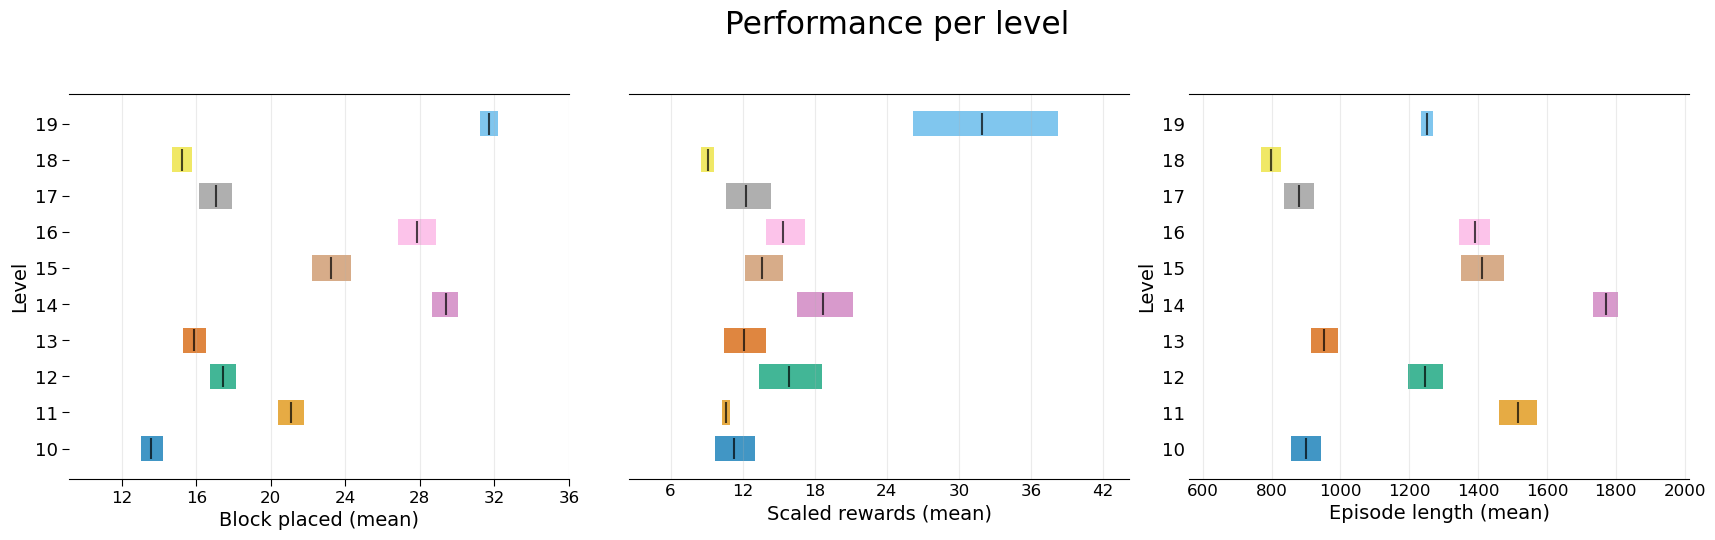

In [76]:
subpop_mean = level_df_mean[level_df_mean["level"] > 9]
plot_interval(subpop_mean, "Performance per level", subpop_mean.parameter.unique(), subpop_mean.level.unique(), agg="mean")

In [132]:
level_data = []
for i, parameter in enumerate(["block_placed", "scaled_rewards", "episode_length", "softdrop_rewards"]):
    for i in range(11):
        data_level = data[data["level"] == i+9]
        stats, lb, ub, mean, std = confidence_intervals(data_level, parameter, aggregate="iqm")
        level_data.append([stats, lb, ub, mean, std, i + 9, parameter])

level_df_2nd = pd.DataFrame(
    level_data,
    columns=["stat", "lower_bound", "upper_bound", "mean", "std", "level", "parameter"],
).drop(columns=['stat'])
level_df_2nd.head()

,lower_bound,upper_bound,mean,std,level,parameter
0,28.603095,30.276352,29.451817,0.455829,9,block_placed
1,12.042239,13.490575,12.728502,0.414243,10,block_placed
2,20.113155,22.342750,21.136616,0.550386,11,block_placed
3,16.053525,18.275910,17.058678,0.599449,12,block_placed
4,14.186615,16.192411,14.948322,0.517265,13,block_placed


(<Figure size 2400x550 with 4 Axes>,
 array([<Axes: xlabel='Block placed (IQM)', ylabel='Level'>,
        <Axes: xlabel='Scaled rewards (IQM)'>,
        <Axes: xlabel='Episode length (IQM)', ylabel='Level'>,
        <Axes: xlabel='Softdrop rewards (IQM)'>], dtype=object))

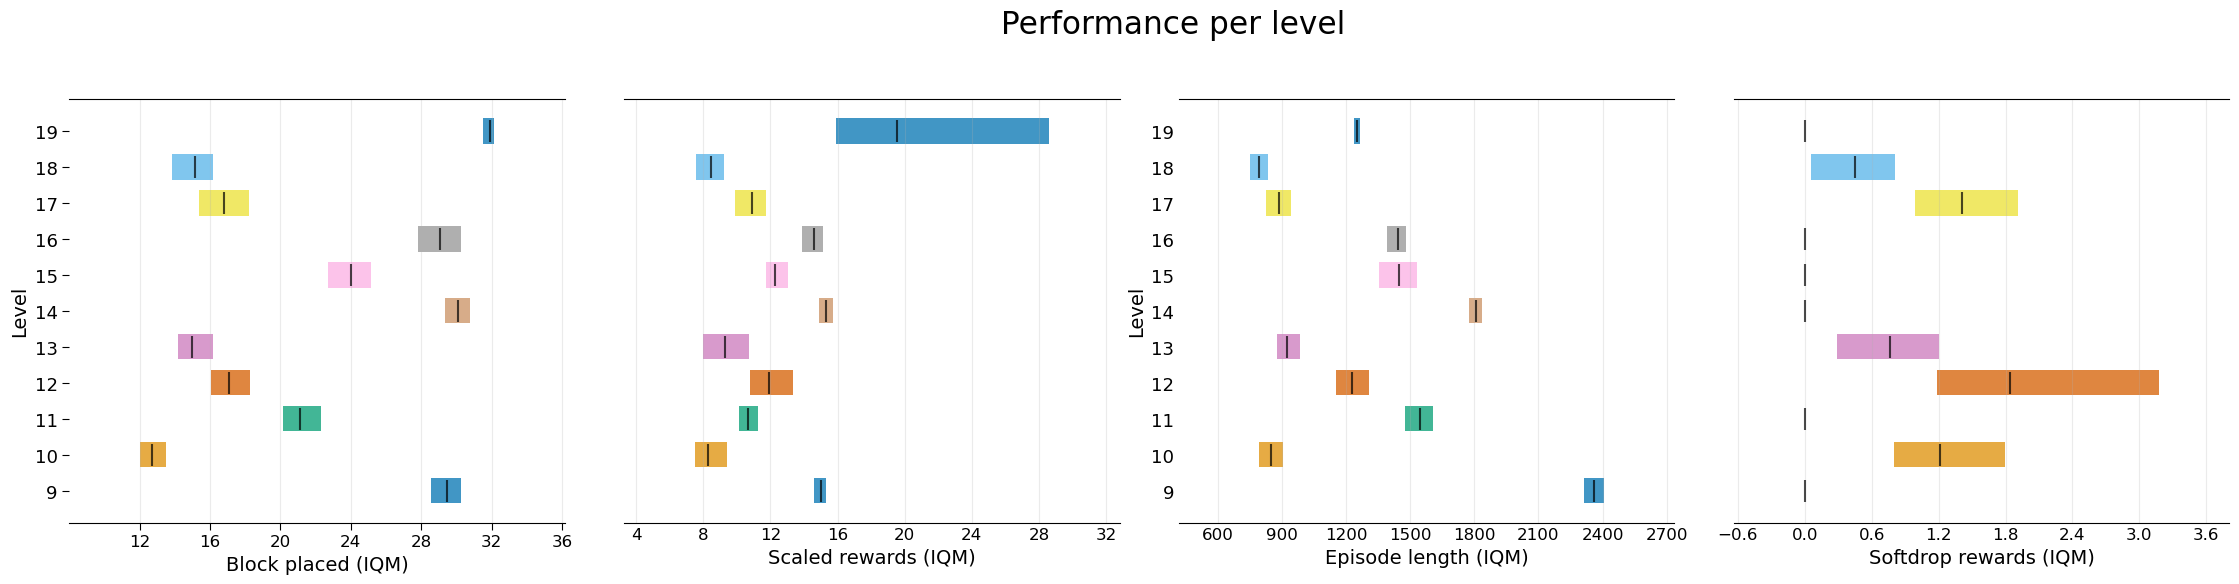

In [34]:
plot_interval(level_df_2nd, "Performance per level", level_df_2nd.parameter.unique(), level_df_2nd.level.unique())

(<Figure size 1800x550 with 3 Axes>,
 array([<Axes: xlabel='Block placed (IQM)', ylabel='Level'>,
        <Axes: xlabel='Scaled rewards (IQM)'>,
        <Axes: xlabel='Episode length (IQM)', ylabel='Level'>],
       dtype=object))

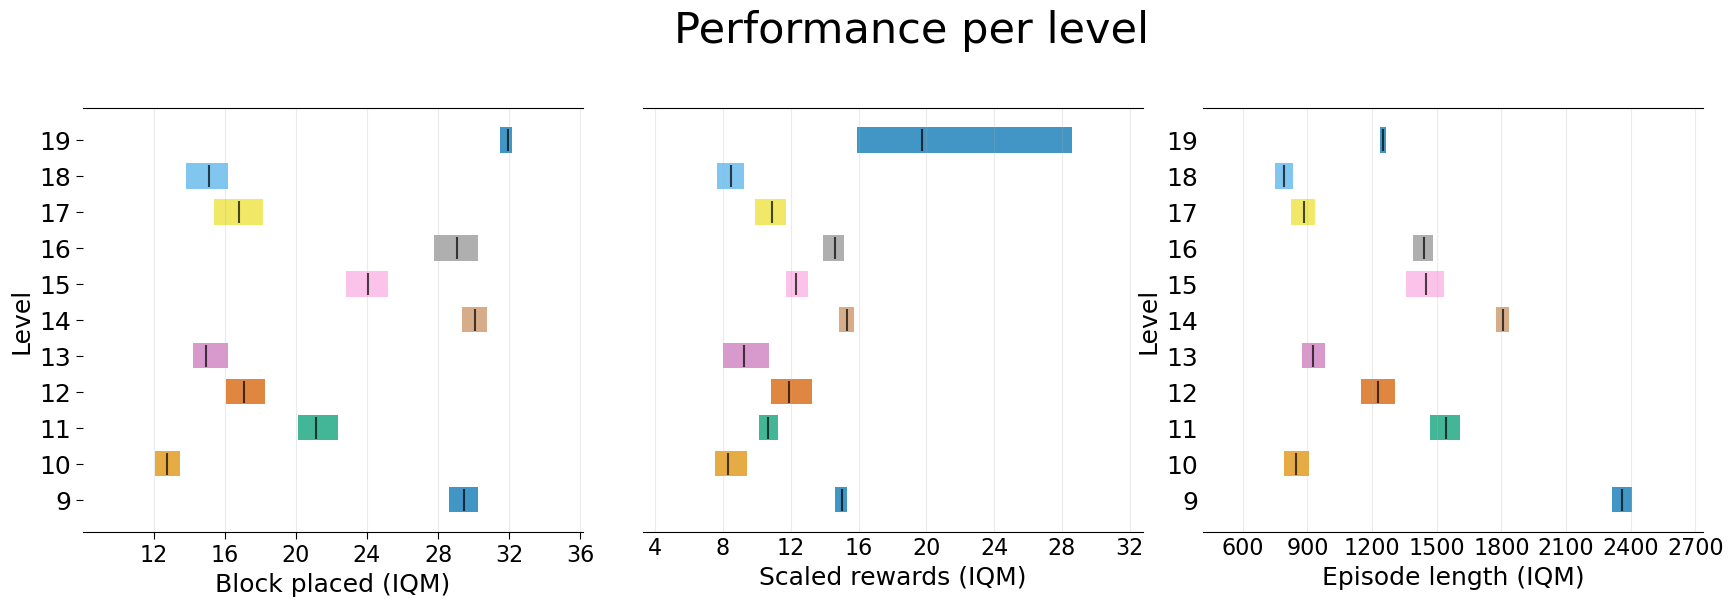

In [197]:
comparison_data = level_df_2nd
plot_interval(comparison_data, "Performance per level", comparison_data.parameter.unique()[:3], comparison_data.level.unique())

In [ ]:
846.242
1542.385
1229.485
924.314
1807.363
1449.342
1440.263
883.035
791.598
1252.964

In [199]:
level_df.set_index("parameter").round(3)

,lower_bound,upper_bound,mean,std,level
parameter,,,,,
block_placed,28.613,30.286,29.457,0.456,9
block_placed,12.029,13.482,12.729,0.421,10
block_placed,20.121,22.354,21.130,0.551,11
block_placed,16.085,18.322,17.083,0.600,12
block_placed,14.194,16.167,14.949,0.520,13
block_placed,29.339,30.746,30.063,0.360,14
block_placed,22.725,25.143,24.042,0.632,15
block_placed,27.836,30.274,29.094,0.665,16
block_placed,15.403,18.143,16.802,0.750,17


In [433]:
level_df.set_index("parameter").to_csv("UNREAL-eval/generalize/CI.csv")

In [187]:
data[data["level"] == 9]

,lines,score,rewards,block_placed,episode_time,episode_length,action_taken,lines_history,board_history,level,scaled_rewards,softdrop_rewards,normalized_rewards
0,0,0,-235.41,32,38.333931,2567,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",[],"[[0, 0, 9, 0, 1, 1, 1, 2, 2, 0], [0, 0, 9, 0, ...",9,16.0,0,0.096070
1,0,0,-231.93,28,34.883907,2173,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...",[],"[[9, 9, 0, 0, 1, 1, 2, 0, 0, 0], [10, 9, 0, 0,...",9,14.0,0,0.078603
2,0,2,-223.11,28,36.724746,2359,"[1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...",[],"[[0, 0, 0, 0, 0, 0, 3, 3, 0, 0], [7, 0, 0, 0, ...",9,16.0,2,0.096070
3,0,0,-218.70,28,38.298395,2359,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...",[],"[[0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, ...",9,14.0,0,0.078603
4,0,0,-233.34,31,39.805633,2457,"[1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...",[],"[[0, 0, 0, 0, 0, 1, 3, 3, 0, 0], [0, 7, 0, 0, ...",9,15.5,0,0.091703
5,0,0,-228.06,29,32.315396,2309,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...",[],"[[0, 0, 0, 0, 1, 1, 4, 4, 0, 0], [0, 0, 0, 0, ...",9,14.5,0,0.082969
6,1,400,-170.83,24,31.598870,2207,"[2, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...",[1],"[[0, 0, 0, 0, 0, 1, 1, 0, 0, 0], [0, 0, 0, 0, ...",9,52.0,0,0.410480
7,0,0,-236.91,25,26.974449,1993,"[4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...",[],"[[0, 0, 0, 0, 0, 0, 2, 2, 0, 0], [0, 0, 0, 0, ...",9,12.5,0,0.065502
8,0,0,-232.80,32,33.280225,2439,"[4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...",[],"[[9, 0, 7, 7, 0, 0, 0, 2, 2, 2], [9, 0, 7, 7, ...",9,16.0,0,0.096070
9,0,0,-206.45,21,24.227241,1783,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...",[],"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...",9,10.5,0,0.048035


In [ ]:
plt.figure(figsize=(12, 8))  # You can adjust the size
ax = sns.heatmap(action_data, annot=True, fmt='d', linewidths=0.5, yticklabels=action_data.index, annot_kws={"size": 18})

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)  # Ukuran font ticks colorbar

# Add labels and title
plt.title('\nHeatmap aksi per Level\n', fontsize=18)
plt.xlabel('\nActions\n', fontsize=18)
plt.ylabel('Level', fontsize=18)

# Show the heatmap
plt.show()

In [73]:
summary_df = data.groupby("level").agg(
    avg_reward=("scaled_rewards", "mean"),
    avg_blocks=("block_placed", "mean"),
    avg_episode_length=("episode_length", "mean"),
    avg_lines=("lines", "mean"),
    avg_softdrop=("softdrop_rewards", "mean")
).reset_index()